In [1]:
import os
from zipfile import ZipFile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import networkx as nx

from fuzzywuzzy import fuzz
from sentence_transformers import SentenceTransformer
import hdbscan

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, regexp_replace, lower, trim
from pyspark.sql import functions as F

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-27 20:49:57.782013: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Data Collection and Modeling
The dataset was imported using the Kaggle Public API.
The dataset contains book reviews written by users on the Amazon platform, including detailed information about the books and users.

In [2]:
os.environ['KAGGLE_USERNAME'] = "tommasopremoli"
os.environ['KAGGLE_KEY'] = "da80d22ca232ce2abb3919d3c02c5163"

In [3]:
zip_path = "./data/amazon-books-reviews.zip"
csv_path = "./data/Books_rating.csv"

In [4]:
os.system("kaggle datasets download -d mohamedbakhet/amazon-books-reviews -p ./dataset")

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
amazon-books-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


0

In [5]:
with ZipFile('dataset/amazon-books-reviews.zip', 'r') as zip_object:
    zip_object.extractall('dataset')

### 1.1. Spark Initialization for Data Model

For modeling and creating the final dataset, Spark was used, which allows for the efficient management of large datasets.

Two main files were ingested:
- **reviews**: contains reviews and ratings assigned by users to different books;
- **book_info**: represents a table of master data relating to books, which lists the main descriptive and technical characteristics.

In [6]:
## Start SparkSession 
spark = SparkSession.builder \
      .master("local[*]") \
      .appName("market_basket_analysis") \
      .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/27 20:50:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
reviews = (
    spark.read
    .option("header", True)
    .option("quote", '"')          
    .option("escape", '"')         
    .option("multiLine", True)    
    .option("sep", ",")          
    .csv("dataset/Books_rating.csv")
)

In [8]:
book_info = (
    spark.read
    .option("header", True)
    .option("quote", '"')    
    .option("escape", '"')    
    .option("multiLine", True)   
    .option("sep", ",")           
    .csv("dataset/books_data.csv")
)

In [9]:
reviews.orderBy("Id").show(10)

+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|        Id|               Title|Price|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|
+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|0001047604|        Aurora Leigh| NULL| A8G9GETA2OLMZ|       P. Schumacher|               9/9|         5.0| 1130457600|As If Jane Eyre W...|Having been broug...|
|0001047604|        Aurora Leigh| NULL|A1ZQ1LUQ9R6JHZ|     Daniel Robinson|             12/13|         5.0|  990316800|An amazing achiev...|E.B.B. set out to...|
|0001047604|        Aurora Leigh| NULL|A2SOBQ2AP72BNY|Nancy L. Pridgen ...|               2/2|         1.0| 1310947200|Aurora Leigh from...|I bought this boo...|
|0001047604|        Aurora L

In [10]:
book_info.show(5)

+--------------------+--------------------+-------------------+--------------------+--------------------+---------+-------------+--------------------+--------------------+------------+
|               Title|         description|            authors|               image|         previewLink|publisher|publishedDate|            infoLink|          categories|ratingsCount|
+--------------------+--------------------+-------------------+--------------------+--------------------+---------+-------------+--------------------+--------------------+------------+
|Its Only Art If I...|                NULL|   ['Julie Strain']|http://books.goog...|http://books.goog...|     NULL|         1996|http://books.goog...|['Comics & Graphi...|        NULL|
|Dr. Seuss: Americ...|Philip Nel takes ...|     ['Philip Nel']|http://books.goog...|http://books.goog...|A&C Black|   2005-01-01|http://books.goog...|['Biography & Aut...|        NULL|
|Wonderful Worship...|This resource inc...|   ['David R. Ray']|http://books

In [11]:
reviews.count()

3000000

The dataset we will be using (reviews) consists of 3 million rows. The dataset containing information about the books was used to perform a join based on the book title, with the aim of integrating the category to which each volume belongs into the main dataset. This field may be extremely useful for the analysis we are going to conduct.

In [12]:
reviews = reviews.join(book_info.select("Title", "categories"), on = "Title", how = "left")
reviews.show()

+--------------------+----------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+--------------------+
|               Title|        Id|Price|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|          categories|
+--------------------+----------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+--------------------+
|Dr. Seuss: Americ...|0826414346| NULL|A30TK6U7DNS82R|       Kevin Killian|             10/10|         5.0| 1095724800|   Really Enjoyed It|I don't care much...|['Biography & Aut...|
|Dr. Seuss: Americ...|0826414346| NULL|A3UH4UZ4RSVO82|        John Granger|             10/11|         5.0| 1078790400|Essential for eve...|If people become ...|['Biography & Aut...|
|Dr. Seuss: Americ...|0826414346| NULL|A2MVUWT453QH61|Roy E. Perry "ama...|          

Only the columns relevant to the analysis are selected from the integrated dataset obtained.
The fields are then renamed in order to adopt a more consistent and standardized nomenclature, so that a greater legibility is guaranteed.

In [13]:
# use only the necessary columns for the analysis
reviews = reviews.select("Id", "Title", "User_id", "profileName", "review/score", "categories")
reviews.orderBy("Id").show(20)

+----------+--------------------+--------------+--------------------+------------+------------------+
|        Id|               Title|       User_id|         profileName|review/score|        categories|
+----------+--------------------+--------------+--------------------+------------+------------------+
|0001047604|        Aurora Leigh| A8G9GETA2OLMZ|       P. Schumacher|         5.0|['English poetry']|
|0001047604|        Aurora Leigh|A1ZQ1LUQ9R6JHZ|     Daniel Robinson|         5.0|['English poetry']|
|0001047604|        Aurora Leigh|A2SOBQ2AP72BNY|Nancy L. Pridgen ...|         1.0|['English poetry']|
|0001047604|        Aurora Leigh| ALSOPPC6O0KKE|              brenna|         1.0|['English poetry']|
|0001047655|The Prodigal Daug...|A3U9ZB72H7QM2P|         Mike Wilson|         1.0|       ['Fiction']|
|0001047655|The Prodigal Daug...| A50X0JTGNR28S|                 Amy|         5.0|       ['Fiction']|
|0001047655|The Prodigal Daug...|A35GRXGR86NB6N|SERGIOPAREDES@YAH...|         5.0|

In [14]:
# rename columns
reviews = reviews.select(
    col('Id').alias('book_id'),
    col('Title').alias('book_title_ds'),
    col('User_id').alias('user_id'),
    col('profileName').alias('profile_name_ds'),
    col('review/score').alias('score_nm'),
    col('categories').alias('category_ds')
)
reviews.orderBy("Id").show(20)

+----------+--------------------+--------------+--------------------+--------+------------------+
|   book_id|       book_title_ds|       user_id|     profile_name_ds|score_nm|       category_ds|
+----------+--------------------+--------------+--------------------+--------+------------------+
|0001047604|        Aurora Leigh| A8G9GETA2OLMZ|       P. Schumacher|     5.0|['English poetry']|
|0001047604|        Aurora Leigh|A1ZQ1LUQ9R6JHZ|     Daniel Robinson|     5.0|['English poetry']|
|0001047604|        Aurora Leigh|A2SOBQ2AP72BNY|Nancy L. Pridgen ...|     1.0|['English poetry']|
|0001047604|        Aurora Leigh| ALSOPPC6O0KKE|              brenna|     1.0|['English poetry']|
|0001047655|The Prodigal Daug...|A3U9ZB72H7QM2P|         Mike Wilson|     1.0|       ['Fiction']|
|0001047655|The Prodigal Daug...| A50X0JTGNR28S|                 Amy|     5.0|       ['Fiction']|
|0001047655|The Prodigal Daug...|A35GRXGR86NB6N|SERGIOPAREDES@YAH...|     5.0|       ['Fiction']|
|0001047655|The Prod

The rows and null values have been removed without reducing the number of rows.

In [15]:
# drop duplicates
reviews.drop_duplicates()

DataFrame[book_id: string, book_title_ds: string, user_id: string, profile_name_ds: string, score_nm: string, category_ds: string]

In [16]:
# drop null
reviews.dropna()

DataFrame[book_id: string, book_title_ds: string, user_id: string, profile_name_ds: string, score_nm: string, category_ds: string]

In [17]:
reviews.count()

3000000

### 1.2. Row Reduction Strategies

To reduce the number of rows in the dataset and obtain a more consistent and meaningful database, some targeted filtering measures were applied:

- **Filtering by active users**: Only users who wrote at least six reviews were retained. This choice allows us to consider only users with greater experience and involvement in the evaluation process, ensuring reviews that are, on average, more reliable and representative.

- **Filtering by popular books**: Only books that received more than 80 reviews in total were included. This filter was introduced to exclude titles that are less well known or less common, focusing the analysis on works that are more popular and relevant to the public.

Applying these criteria made it possible to reduce the size of the dataset, improving the quality of the analysis.

In [18]:
# 1. Only keep users who have reviewed at least 6 books
user_counts = reviews.groupBy("user_id").agg(count("book_title_ds").alias("count"))
user_counts.show(10)

+--------------+-----+
|       user_id|count|
+--------------+-----+
|A3NY9NLY7YQZIL|    1|
|A13Z0IGUFQBJ4X|    3|
| APDR8MY8AN1NU|    1|
|A2TD04KIWOYTYN|    3|
|A2KABNNIF9VNKI|    1|
|A1AFJQQV3ZDJQA|   23|
|A1G8VN8CGFD0Y7|   16|
| AN8CIOCJX82BA|    8|
|A2P9FK07ITFAC3|    8|
| A1UK8XAWG82A5|    8|
+--------------+-----+
only showing top 10 rows


In [19]:
user_counts = reviews.groupBy("user_id").agg(count("book_id").alias("n_books"))

filtered_reviews = reviews.join(user_counts, on = "user_id", how = "inner").filter("n_books >= 6")

filtered_reviews = filtered_reviews.select(
    "user_id",
    "book_id",
    "book_title_ds",
    "profile_name_ds",
    "score_nm",
    "category_ds"

)

filtered_reviews.show(10)

+--------------------+----------+--------------------+---------------+--------+--------------------+
|             user_id|   book_id|       book_title_ds|profile_name_ds|score_nm|         category_ds|
+--------------------+----------+--------------------+---------------+--------+--------------------+
|A00540411RKGTDNU5...|B000NDSX6C|          The Hobbit|    Keith Smith|     5.0|['Juvenile Fiction']|
|A00540411RKGTDNU5...|B000NWQXBA|          The Hobbit|    Keith Smith|     5.0|['Juvenile Fiction']|
|A00540411RKGTDNU5...|B000PC54NG|          The Hobbit|    Keith Smith|     5.0|['Juvenile Fiction']|
|A00540411RKGTDNU5...|B000GQG7D2|          The Hobbit|    Keith Smith|     5.0|['Juvenile Fiction']|
|A00540411RKGTDNU5...|B000H9R1Q0|          The Hobbit|    Keith Smith|     5.0|['Juvenile Fiction']|
|A00540411RKGTDNU5...|B000GQG5MA|The Hobbit; Or, T...|    Keith Smith|     5.0|                NULL|
|A00540411RKGTDNU5...|B000ILIJE0|The Hobbit There ...|    Keith Smith|     5.0|['Adventure 

In [20]:
# filter to remove books that have been reviewed less than 80 times
book_counts = (
    filtered_reviews
    .groupBy("book_id", "book_title_ds")
    .agg(count("user_id").alias("n_users"))
)
book_counts.show()

+----------+--------------------+-------+
|   book_id|       book_title_ds|n_users|
+----------+--------------------+-------+
|B0008CNCHI|Little women, or,...|    656|
|0758204116|       The Way It Is|      7|
|0786261080|Alice's Adventure...|    706|
|B0002QUWRS|The Punch: One Ni...|     29|
|B000NQ9QF6|Slaughter-House Five|    832|
|B000PC53ZK|  THE SUN ALSO RISES|    358|
|B000CKENHE|Slapstick: Or Lon...|     24|
|B000MUBGFG|China : A History...|      1|
|0571211941|Turn the Beat Aro...|      6|
|0714837431|Contemporary Worl...|      1|
|0826339972|Broken Glass: A F...|      1|
|B000N8RIMC|       I'm a Manatee|      5|
|0613532961|           Plainsong|    165|
|B000879GVO|The adventures of...|      2|
|0971953880|When You Work for...|      4|
|0939837552|Cruising Guide to...|      1|
|1587680327|Paul of Tarsus: A...|      3|
|0072192623|Windows 2000 (Hac...|      3|
|0873588282|Do Princesses Wea...|      6|
|1591022312|The Joy of Chemis...|      5|
+----------+--------------------+-

In [21]:
min_reviews = 80 # threshold set to 80 reviews

popular_books = (
    filtered_reviews
    .join(book_counts, on=["book_id", "book_title_ds"], how="inner")
    .filter(col("n_users") >= min_reviews)
)

popular_books = popular_books.select(
    "user_id",
    "book_id",
    "book_title_ds",
    "profile_name_ds",
    "score_nm",
    "category_ds"
)

popular_books.show(10, truncate=False)

+--------------+----------+------------------------------------------------------------------------------------+------------------------------+--------+-----------+
|user_id       |book_id   |book_title_ds                                                                       |profile_name_ds               |score_nm|category_ds|
+--------------+----------+------------------------------------------------------------------------------------+------------------------------+--------+-----------+
|A11D9S9R0GUK20|0060765461|The Lion, the Witch and the Wardrobe Movie Tie-in Edition (The Chronicles of Narnia)|ANM1                          |4.0     |NULL       |
|A1GARI2JT6EAWA|0060765461|The Lion, the Witch and the Wardrobe Movie Tie-in Edition (The Chronicles of Narnia)|DWD "DWD's Reviews"           |4.0     |NULL       |
|A1H8318515M7I |0060765461|The Lion, the Witch and the Wardrobe Movie Tie-in Edition (The Chronicles of Narnia)|Justine21                     |5.0     |NULL       |
|A1IF1E4TQ

In [22]:
popular_books.count()

526802

Applying the filters described above reduced the dataset to a total of 526,802 reviews.
This reduction allows for a more focused and meaningful analysis, while improving the quality of the results and the computational efficiency of follow-up calculations.

### 1.3. Title Normalization

The main objective of this phase of the analysis is to ensure consistency and uniqueness in book titles, so that centrality measures (such as PageRank) and other network metrics can be calculated correctly.
During the preliminary stages, it emerged that numerous books, despite referring to the same volume, had different titles due to variations related to the edition, punctuation, format (e.g., audiobook), or the presence of additional terms (such as “illustrated,” “volume,” “classic edition,” etc.).
This heterogeneity created duplications and distortions in the analyses, as the same book could appear in several distinct nodes of the graph, generating different PageRank values.

1. **Preliminary text cleaning**: In the first phase, titles were converted to lowercase and cleaned up to remove multiple spaces, punctuation, and special characters.

2. **Removal of stopwords**: Next, semantic filtering was applied, eliminating recurring but insignificant terms.

3. **Unification through textual similarity (fuzzy matching)**: An approach based on string similarity was used, calculated using the token set ratio metric.

4. **Semantic clustering with embedding models**: A method based on semantic representations of titles was adopted.

In [23]:
popular_books = popular_books.withColumn(
    "book_title_ds",
    F.trim(
        F.regexp_replace(                   
            F.regexp_replace(                
                F.lower(F.col("book_title_ds")),
                "[^a-z0-9 ]", ""
            ),
            r"\s+", " "
        )
    )
)

In [24]:
titles = [r['book_title_ds'] for r in popular_books.select("book_title_ds").distinct().collect()]
print(len(titles), "unique titles")

1205 unique titles


In [25]:
stopwords = [
    "edition", "illustrated", "school library", "classic library", "volume", "classics", "audiobook", "audio", "author",
    "penguin classics", "everyman", "new windmill", "hardcover", "book", "collected", "english", "trilogy", "volumes"
]

for w in stopwords:
    popular_books = popular_books.withColumn(
        "book_title_ds",
        trim(regexp_replace(lower("book_title_ds"), w, ""))
    )

In [26]:
threshold = 90  # similarity percentage

canonical_titles = []
clusters = {}

for title in titles:
    if title in clusters:
        continue
    matches = [t for t in titles if fuzz.token_set_ratio(title, t) >= threshold]
    canonical = max(matches, key=len)  
    for m in matches:
        clusters[m] = canonical
    canonical_titles.append(canonical)

print(len(canonical_titles), "canonical titles identified")

825 canonical titles identified


In [27]:
mapping_df = pd.DataFrame(list(clusters.items()), columns=["book_title_ds", "canonical_title"])
mapping_spark = spark.createDataFrame(mapping_df)

In [28]:
popular_books = (
    popular_books
    .join(mapping_spark, on="book_title_ds", how="left")
    .withColumn("book_title_ds", F.coalesce(F.col("canonical_title"), F.col("book_title_ds")))
    .drop("canonical_title")
)

In [29]:
titles = [r['book_title_ds'] for r in popular_books.select("book_title_ds").distinct().collect()]
titles = [t for t in titles if t and len(t.strip()) > 0]


model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(titles, convert_to_numpy=True, show_progress_bar=True, normalize_embeddings=True)

clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean', cluster_selection_epsilon=0.05)
cluster_labels = clusterer.fit_predict(embeddings)

df_clusters = pd.DataFrame({
    'title': titles,
    'cluster': cluster_labels
})

canonical_map = {}
for label, group in df_clusters.groupby('cluster'):
    if label == -1:
        for t in group['title']:
            canonical_map[t] = t
    else:
        canonical = min(group['title'], key=len)
        for t in group['title']:
            canonical_map[t] = canonical

print(f"Cluster found: {df_clusters['cluster'].nunique()}")

mapping_df = pd.DataFrame(list(canonical_map.items()), columns=['book_title_ds', 'canonical_title'])
mapping_spark = spark.createDataFrame(mapping_df)

popular_books = (
    popular_books
    .join(mapping_spark, on="book_title_ds", how="left")
    .withColumn("book_title_ds", F.coalesce(F.col("canonical_title"), F.col("book_title_ds")))
    .drop("canonical_title")
)

Batches: 100%|██████████| 31/31 [00:08<00:00,  3.76it/s]                        


Cluster found: 97


In [30]:
book_df = popular_books.select("book_title_ds", "user_id", "profile_name_ds", "score_nm", "category_ds").distinct()

In [31]:
book_df.count()

242905

After creating a distinct list of the new dataset with the right titles, we obtained 242,905 rows.

In [32]:
book_df.show(20)

+--------------------+--------------+--------------------+--------+--------------------+
|       book_title_ds|       user_id|     profile_name_ds|score_nm|         category_ds|
+--------------------+--------------+--------------------+--------+--------------------+
|casino royale bul...| ALH1W9IJQQH2E|     James H. Felder|     4.0| ['English fiction']|
|alices adventures...|A30UWBHC4QL4JT|          S. Robison|     3.0|         ['Fiction']|
|alices adventures...|A1AKC5L44ANZZN|John P. Gelinas "...|     5.0|         ['Fiction']|
|the hound of the ...|A3MV1KKHX51FYT|      Acute Observer|     5.0|         ['Fiction']|
|           plainsong|A2NS4ZOVB28DK4|          Maria Atas|     3.0|         ['Fiction']|
|           plainsong|A1Q329PGKOGLDD|         Chad Spivak|     5.0|         ['Fiction']|
|           plainsong|A2Q0GY15SDWZVS|        Emma K. Tsai|     4.0|         ['Fiction']|
|the mysterious is...|A26C1TX67IDQVJ|        Greg Foreman|     5.0|         ['Fiction']|
|the mysterious is...

### 1.4. Random Sample
Finally, as the last step in preparation before starting the actual analysis, a sample of the dataset was extracted. Specifically, 35% of the total rows were selected, resulting in a final dataset consisting of 85,067 observations.

In [33]:
# final random selection
book_df_final = book_df.sample(False, 0.35, seed=123)
book_df_final.count()

85067

In [34]:
book_df_final.show(5)

+--------------------+--------------+---------------+--------+-------------------+
|       book_title_ds|       user_id|profile_name_ds|score_nm|        category_ds|
+--------------------+--------------+---------------+--------+-------------------+
|casino royale bul...| ALH1W9IJQQH2E|James H. Felder|     4.0|['English fiction']|
|the hound of the ...|A3MV1KKHX51FYT| Acute Observer|     5.0|        ['Fiction']|
|           plainsong|A2NS4ZOVB28DK4|     Maria Atas|     3.0|        ['Fiction']|
|the butlerian jih...| AFYU5LXHZO5M3|  Vilbs "vilbs"|     5.0|            ['Art']|
|great expectation...|A1DKQCC90FY7NX| mzgambler "Mz"|     5.0|        ['Fiction']|
+--------------------+--------------+---------------+--------+-------------------+
only showing top 5 rows


In [35]:
# download the dataset
book_df_final = book_df_final.toPandas()
book_df_final.to_csv('dataset/book_df.csv', index=False)

## 2. Exploratory Data Analysis (EDA)
This phase aims to analyze certain characteristics of the final dataset that has been created.

In [36]:
book_df = pd.read_csv('dataset/book_df.csv')
book_df.head(15)

,book_title_ds,user_id,profile_name_ds,score_nm,category_ds
0,casino royale bullseye,ALH1W9IJQQH2E,James H. Felder,4.0,['English fiction']
1,the hound of the baskervilles signet,A3MV1KKHX51FYT,Acute Observer,5.0,['Fiction']
2,plainsong,A2NS4ZOVB28DK4,Maria Atas,3.0,['Fiction']
3,the butlerian jihad legends of dune book 1,AFYU5LXHZO5M3,"Vilbs ""vilbs""",5.0,['Art']
4,great expectations signet,A1DKQCC90FY7NX,"mzgambler ""Mz""",5.0,['Fiction']
5,charles dickens pickwick papers,AEMZRE6QYVQBS,David A. Baer,5.0,['England']
6,charles dickens pickwick papers,A1Z07UXQ1ZH07V,Judith Kilpatrick,2.0,['England']
7,rainbow six,A2FS82KFC4NUNR,Cai Yixin Jeremy,5.0,['Games & Activities']
8,red rabbit,A2FT22FKKY7VRK,Paul M. Gunther,1.0,['Intelligence officers']
9,lord of the flies a novel,A1LUM076RXMFNV,Beverly J. Scott,5.0,['Fiction']


As shown in the bar chart below, most books received high ratings, with scores of 4 and especially 5 stars. On the contrary, there are very few books with low ratings.

/var/folders/85/5nsqwlmd1xx9qfh9rn8rll2c0000gn/T/ipykernel_50031/1379090799.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = book_df, x = 'score_nm', palette="crest", alpha=0.5)


<Axes: xlabel='score_nm', ylabel='count'>

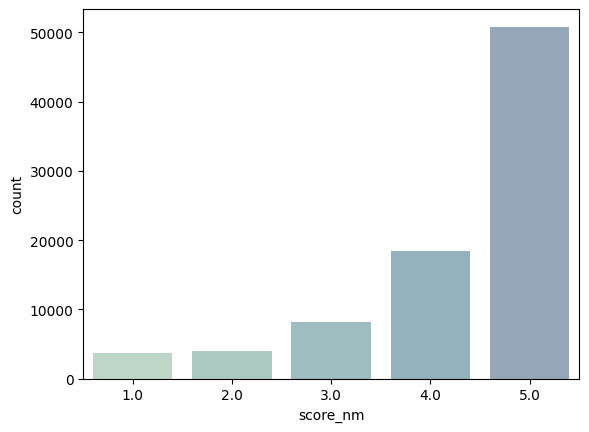

In [37]:
# Distribution of ratings among books
sns.countplot(data = book_df, x = 'score_nm', palette="crest", alpha=0.5)

In [38]:
# Top 30 books with more reviews
top_books = (
    book_df.groupby("book_title_ds")
    .size()                                
    .reset_index(name="num_reviews")      
    .sort_values("num_reviews", ascending=False)
    .head(30)
)

The following bar plot shows the 30 books with the highest number of reviews by Amazon users.
The analysis revealed that two different titles refer to the same book, “The Hobbit,” which appears in second and seventh place.
Since the total number of reviews is particularly high, it was decided to map the two titles to a single item in order to ensure a more consistent PageRank calculation.

/var/folders/85/5nsqwlmd1xx9qfh9rn8rll2c0000gn/T/ipykernel_50031/77668013.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


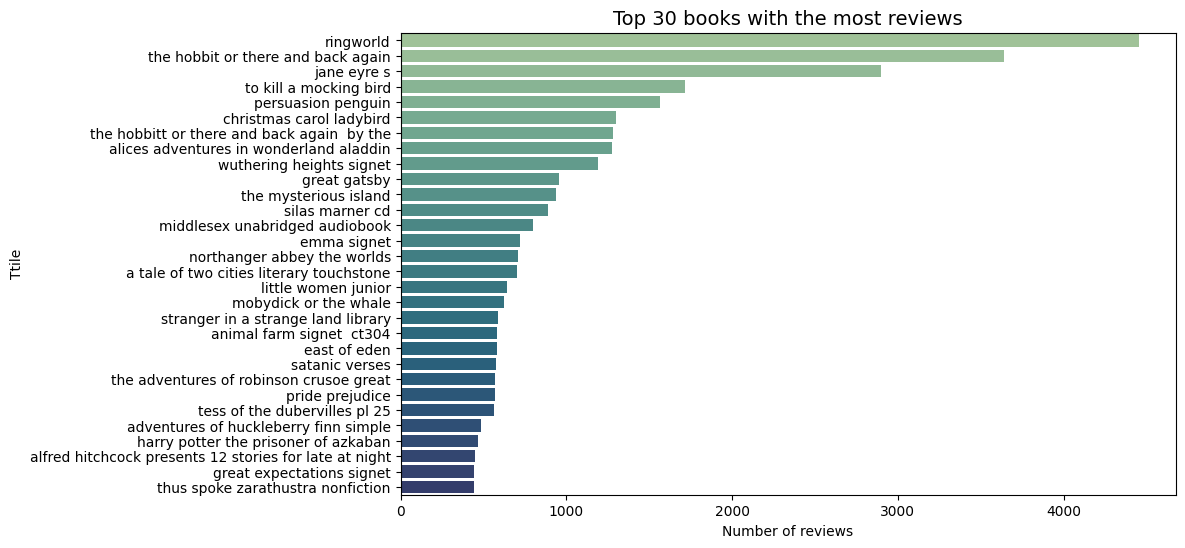

In [39]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_books,
    x="num_reviews",
    y="book_title_ds",
    palette="crest"
)

plt.title("Top 30 books with the most reviews", fontsize=14)
plt.xlabel("Number of reviews")
plt.ylabel("Ttile")
plt.show()

In [40]:
filtered = (
    book_df[
        book_df["book_title_ds"].str.lower().str.contains("hobbit", na=False)
    ]
    .drop_duplicates()
)

filtered.head()

,book_title_ds,user_id,profile_name_ds,score_nm,category_ds
432,the hobbit or there and back again,AF3HP0PEKDMUJ,Pug,5.0,['Juvenile Fiction']
433,the hobbit or there and back again,A1KA11IR1A1IKB,"Jesse ""Jessica Lowery""",5.0,['Juvenile Fiction']
434,the hobbit or there and back again,A3LI9HTR6ALID,alex,5.0,['Juvenile Fiction']
435,the hobbit or there and back again,A3DR1LB8EE942U,"econdude ""econdude""",5.0,['Juvenile Fiction']
436,the hobbit or there and back again,A28WJUJF6D2ULA,Notnadia,5.0,['Juvenile Fiction']


In [41]:
book_df["book_title_ds"] = book_df["book_title_ds"].replace(
    {"the hobbitt or there and back again  by the": "the hobbit or there and back again"}
)

Below you can see the review count calculated correctly.

/var/folders/85/5nsqwlmd1xx9qfh9rn8rll2c0000gn/T/ipykernel_50031/1565854996.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


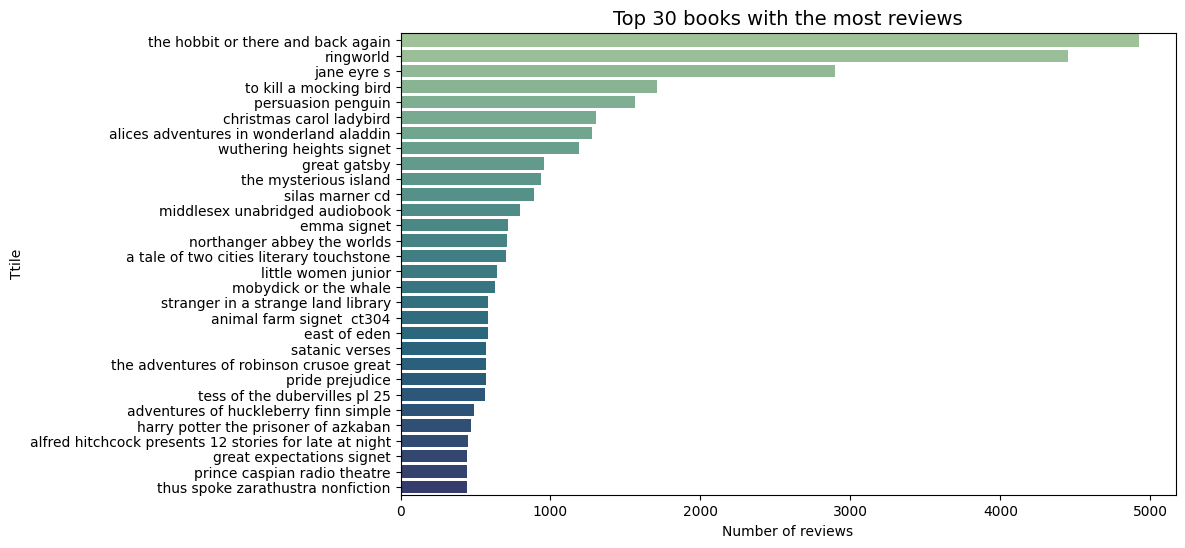

In [42]:
# Top 30 books with more reviews
top_books = (
    book_df.groupby("book_title_ds")
    .size()                                
    .reset_index(name="num_reviews")      
    .sort_values("num_reviews", ascending=False)
    .head(30)
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_books,
    x="num_reviews",
    y="book_title_ds",
    palette="crest"
)

plt.title("Top 30 books with the most reviews", fontsize=14)
plt.xlabel("Number of reviews")
plt.ylabel("Ttile")
plt.show()

## 3. Network Construction

The objective of this analysis is to evaluate the importance of books on the Amazon platform through the application of centrality measures, such as PageRank. 

The first step is to construct the basic dataset needed to create the network. In this dataset, each row represents the association between a user and the book reviewed by that user.

The resulting graph is structured as follows:
- **Nodes**: each node represents a book in the dataset.
- **Edges**: an edge connects two books if they have been reviewed by the same user.
- **Weights**: the weight of the edge indicates the number of users who have reviewed both books.
- **Graph type**: the resulting network is undirected and weighted.

In [43]:
book_df_final = book_df.drop_duplicates(subset=['user_id', 'book_title_ds'])

In [44]:
edges = []

for user, group in book_df_final.groupby('user_id'):
    books = sorted(group['book_title_ds'].unique())
    if len(books) > 1:
        for a, b in itertools.combinations(books, 2):
            edges.append((a, b))

edges_df = pd.DataFrame(edges, columns=['book_i', 'book_j'])
edges_weighted = edges_df.value_counts().reset_index(name='weight')
edges_weighted.head()

,book_i,book_j,weight
0,a tale of two cities literary touchstone,great gatsby,282
1,jane eyre s,wuthering heights signet,273
2,persuasion penguin,wuthering heights signet,240
3,jane eyre s,northanger abbey the worlds,235
4,ringworld,the hobbit or there and back again,230


In [45]:
book_features = (
    book_df_final.groupby(['book_title_ds', 'category_ds'])
    .agg(
        n_users=('user_id', 'nunique')
    )
    .reset_index()
)
book_features.head()

,book_title_ds,category_ds,n_users
0,1491 new revelations of the americas before co...,['History'],69
1,1632 the assiti shards,['Fiction'],30
2,1st to die a novel,['Fiction'],86
3,20 000 leagues under the sea,['Fiction'],89
4,48 laws of power,"['Body, Mind & Spirit']",58


In [46]:
# Graph creation
G = nx.Graph()

# nodes
for _, row in book_features.iterrows():
    G.add_node(row['book_title_ds'],
               category=row['category_ds'],
               n_users=row['n_users'])

# edges
for _, row in edges_weighted.iterrows():
    G.add_edge(row['book_i'], row['book_j'], weight=int(row['weight']))

print(f"This network is composed by has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

This network is composed by has 667 nodes and 71142 edges.


## 4. Network Analysis

In [47]:
avg_deg = sum(dict(G.degree()).values()) / G.number_of_nodes()
print(avg_deg)

213.3193403298351


On average, each book is connected to over 200 other books, which means that more than 200 users on average have reviewed two books connected in the network.

### 4.1. PageRank

In [48]:
pr = nx.pagerank(G, alpha=0.85, weight='weight')
nx.set_node_attributes(G, pr, 'pagerank')

top30 = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:30]
print("Top 30 books by PageRank:")
for t, v in top30:
    print(f"{t:50s}  PR={v:.5f}")

Top 30 books by PageRank:
jane eyre s                                         PR=0.01122
persuasion penguin                                  PR=0.01070
middlesex unabridged audiobook                      PR=0.00954
ringworld                                           PR=0.00914
alfred hitchcock presents 12 stories for late at night  PR=0.00808
to kill a mocking bird                              PR=0.00762
a tale of two cities literary touchstone            PR=0.00679
the hobbit or there and back again                  PR=0.00669
wuthering heights signet                            PR=0.00668
great gatsby                                        PR=0.00626
tara road                                           PR=0.00609
animal farm signet  ct304                           PR=0.00608
fahrenheit 451 cascades s                           PR=0.00574
the mysterious island                               PR=0.00553
silas marner cd                                     PR=0.00544
harry potter the prisoner

/var/folders/85/5nsqwlmd1xx9qfh9rn8rll2c0000gn/T/ipykernel_50031/1606749608.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


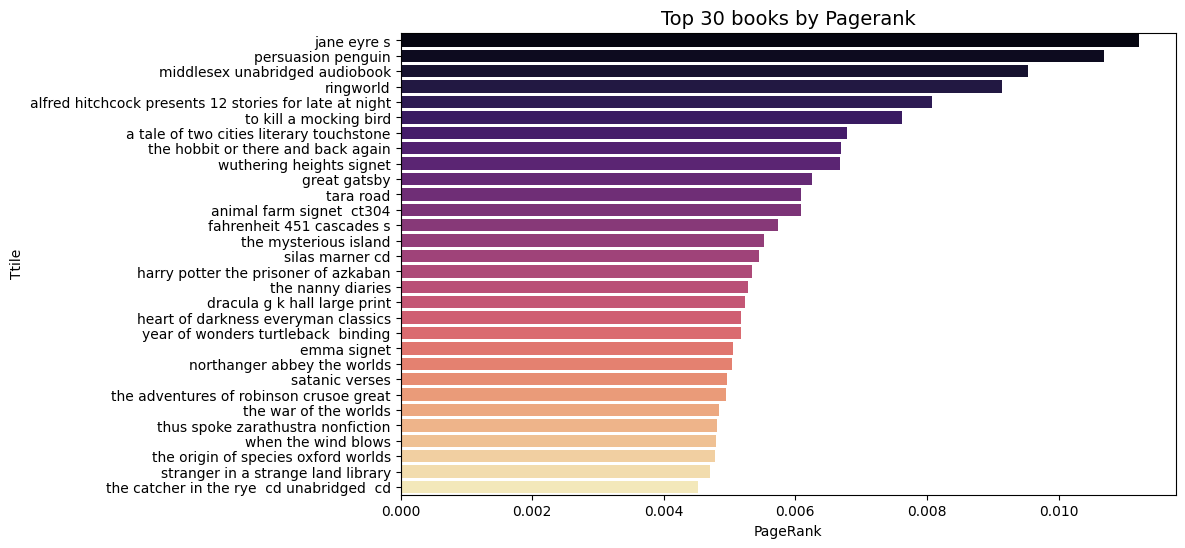

In [49]:
top30_df = pd.DataFrame(top30, columns=["book_title_ds", "pagerank"])

plt.figure(figsize=(10,6))
sns.barplot(
    data=top30_df,
    x="pagerank",
    y="book_title_ds",
    palette="magma"
)

plt.title("Top 30 books by Pagerank", fontsize=14)
plt.xlabel("PageRank")
plt.ylabel("Ttile")
plt.show()

### 4.2. Degree Analysis

In this second part of the chapter, the goal is to calculate some fundamental measures of network analysis such as density, degree centrality, closeness centrality, and betweenness centrality.

In [50]:
degrees = list(dict(G.degree()).values())
avg_degree = np.mean(degrees)
std_degree = np.std(degrees)
min_degree = np.min(degrees)
max_degree = np.max(degrees)

print(f'Minimum degree: {min_degree}')
print(f'Maximum degree: {max_degree}')
print(f'Average degree: {avg_degree}')
print(f'Standard deviation of degrees: {std_degree}')

Minimum degree: 9
Maximum degree: 588
Average degree: 213.3193403298351
Standard deviation of degrees: 111.23722223679958


In [51]:
p = nx.density(G) 
p

0.3202993098045572

In [52]:
def top_n_ranks(centrality, n=10):
    return sorted(centrality, key=centrality.get, reverse=True)[:n]

In [53]:
# Degree centrality
degree_centrality = nx.degree_centrality(G)
print('Top 10 books by degree centrality:')
top_degree_centrality = top_n_ranks(degree_centrality)
for i, book in enumerate(top_degree_centrality):
    print(f'{i + 1}: {book} - {degree_centrality[book]:.4f}')

Top 10 books by degree centrality:
1: alfred hitchcock presents 12 stories for late at night - 0.8829
2: middlesex unabridged audiobook - 0.8829
3: jane eyre s - 0.8754
4: ringworld - 0.8709
5: persuasion penguin - 0.8559
6: to kill a mocking bird - 0.8544
7: tara road - 0.8033
8: fahrenheit 451 cascades s - 0.7853
9: year of wonders turtleback  binding - 0.7793
10: the hobbit or there and back again - 0.7778


In [54]:
# Closeness centrality
close_centrality = nx.closeness_centrality(G) 
print('Top 10 books by closeness centrality:')
top_close_centrality = top_n_ranks(close_centrality)
for i, book in enumerate(top_close_centrality):
    print(f'{i + 1}: {book} - {close_centrality[book]:.4f}')

Top 10 books by closeness centrality:
1: alfred hitchcock presents 12 stories for late at night - 0.8952
2: middlesex unabridged audiobook - 0.8952
3: jane eyre s - 0.8892
4: ringworld - 0.8856
5: persuasion penguin - 0.8740
6: to kill a mocking bird - 0.8729
7: tara road - 0.8356
8: fahrenheit 451 cascades s - 0.8232
9: year of wonders turtleback  binding - 0.8192
10: the hobbit or there and back again - 0.8182


In [55]:
# Betweenness centrality
between_centrality = nx.betweenness_centrality(G, weight='weight') 
print('Top 10 books by betweenness centrality:')
top_between_centrality = top_n_ranks(between_centrality)
for i, book in enumerate(top_between_centrality):
    print(f'{i + 1}: {book} - {between_centrality[book]:.4f}')

Top 10 books by betweenness centrality:
1: cold mountain a novel - 0.0036
2: practical magic - 0.0035
3: the alchemist a fable about following your dream - 0.0034
4: dracula g k hall large print - 0.0033
5: the martian chronicles time reading program - 0.0033
6: when the wind blows - 0.0033
7: one shot jack reacher no 9 - 0.0033
8: new earth - 0.0033
9: eldest inheritance  2 - 0.0032
10: blink the power of thinking without thinking - 0.0032


### 4.3. Network Visualization

The following graph shows the top 50 books by PageRank that are interconnected.

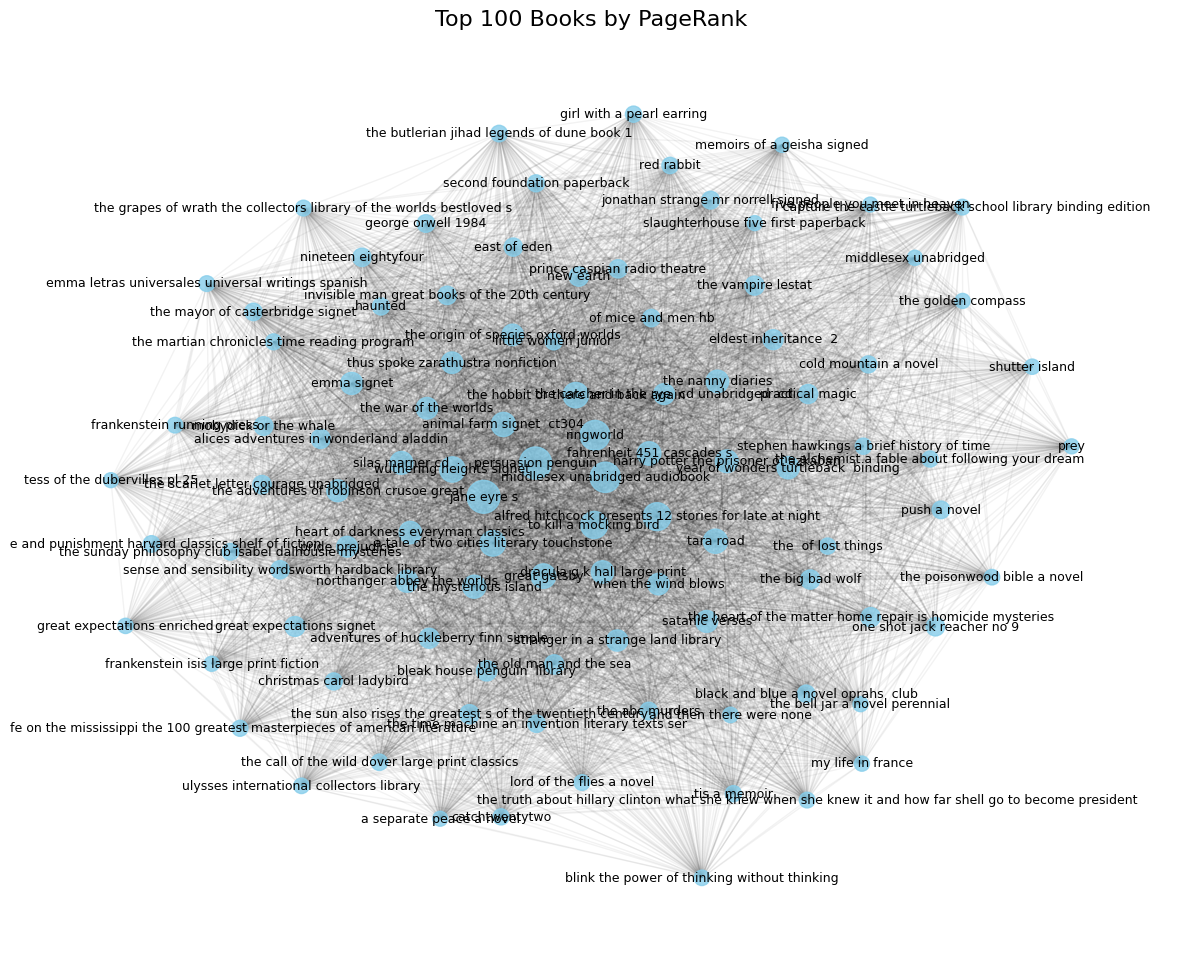

In [56]:
top_nodes = sorted(pr, key=pr.get, reverse=True)[:100]
subG = G.subgraph(top_nodes)

plt.figure(figsize=(15, 12))

pos = nx.spring_layout(subG, k=0.7, seed=42)
node_size = [pr[n] * 50000 for n in subG.nodes()]

node_color = "skyblue"

nx.draw_networkx_nodes(subG, pos, node_size=node_size, node_color=node_color, alpha=0.8)
nx.draw_networkx_edges(subG, pos, alpha=0.05)
nx.draw_networkx_labels(subG, pos, font_size=9, font_family="sans-serif")

plt.title("Top 100 Books by PageRank", fontsize=16)
plt.axis("off")
plt.show()